In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(measurement.date)).scalar()
latest_date

'2017-08-23'

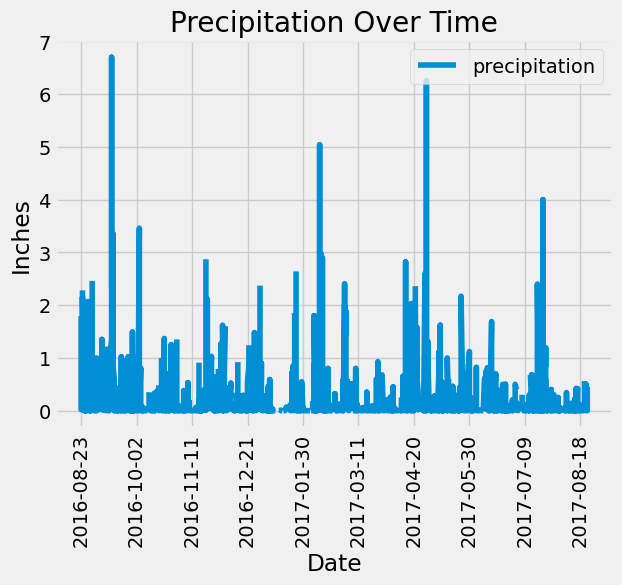

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = latest_date - dt.timedelta(days=365)
start_date = start_date.date()
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date.between(start_date, latest_date))

# Save the query results as a Pandas DataFrame. Explicitly set the column names
result_list = [[result[0], result[1]] for result in results]
columns = ['date', 'precipitation']
percip_df = pd.DataFrame(result_list, columns = columns)

# Sort the dataframe by date
percip_df = percip_df.sort_values('date')
percip_df


# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(percip_df['date'],percip_df['precipitation'], label='precipitation')

# Set plot title and labels
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Inches')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.legend(loc='upper right')
# Specify the frequency of x-axis tick labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(11))
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = percip_df['precipitation'].describe()

# Customize the index labels
summary_stats.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

summary_stats = pd.DataFrame(summary_stats)
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).\
                    all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0].station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == most_active).all()

temperature_stats

# print(f"Lowest Temperature: {lowest_temp}")
# print(f"Highest Temperature: {highest_temp}")
# print(f"Average Temperature: {avg_temp}")

[(54.0, 85.0, 71.66378066378067)]

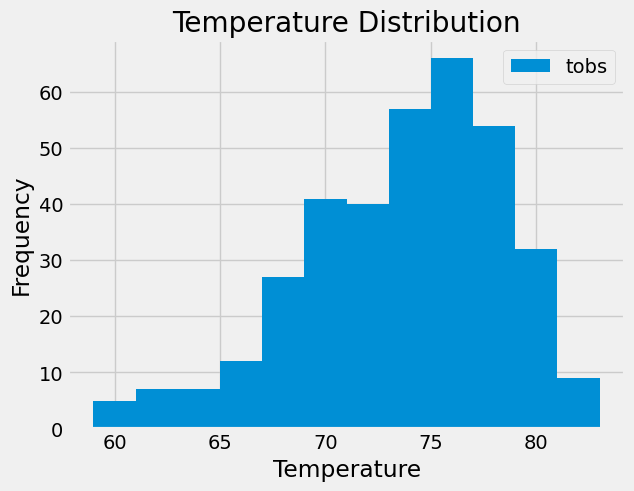

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find the most recent date in the data set.
active_latest_date = session.query(func.max(measurement.date)).filter(measurement.station == most_active).scalar()
active_latest_date = dt.datetime.strptime(active_latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
active_start_date = active_latest_date - dt.timedelta(days=365)
active_start_date = active_start_date.date()
# Perform a query to retrieve tobs 
active_results = session.query(measurement.tobs).filter(measurement.station == most_active, measurement.\
                                                 date.between(active_start_date, active_latest_date)).all()
temperatures = [result[0] for result in active_results]

# Plot the histogram
plt.hist(temperatures, bins=12, label = "tobs")

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.legend(loc='upper right')

# Display the histogram
plt.show()

# Close Session

In [17]:
# Close Session
session.close()